Cel projektu: Przewidywanie poziomu ryzyka wypadku (accident_risk) na podstawie parametrów infrastruktury drogowej (np. road_type, speed_limit) oraz warunków zewnętrznych (np. weather, lighting).

Źródło danych: https://www.kaggle.com/datasets/chetanmittal033/road-accident-dataset

Do projektu wycięto 10 tysięcy danych ze zbioru train.csv.

In [82]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import shap


In [83]:
df = pd.read_csv("./archive/data.csv", encoding='utf-16')

## Analiza danych

In [84]:
df.head(5)

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      10000 non-null  int64  
 1   road_type               10000 non-null  object 
 2   num_lanes               10000 non-null  int64  
 3   curvature               10000 non-null  float64
 4   speed_limit             10000 non-null  int64  
 5   lighting                10000 non-null  object 
 6   weather                 10000 non-null  object 
 7   road_signs_present      10000 non-null  bool   
 8   public_road             10000 non-null  bool   
 9   time_of_day             10000 non-null  object 
 10  holiday                 10000 non-null  bool   
 11  school_season           10000 non-null  bool   
 12  num_reported_accidents  10000 non-null  int64  
 13  accident_risk           10000 non-null  float64
dtypes: bool(4), float64(2), int64(4), objec

Rozkłady zmiennej celu (y = accident_risk) oraz zmiennych objaśniających numerycznych

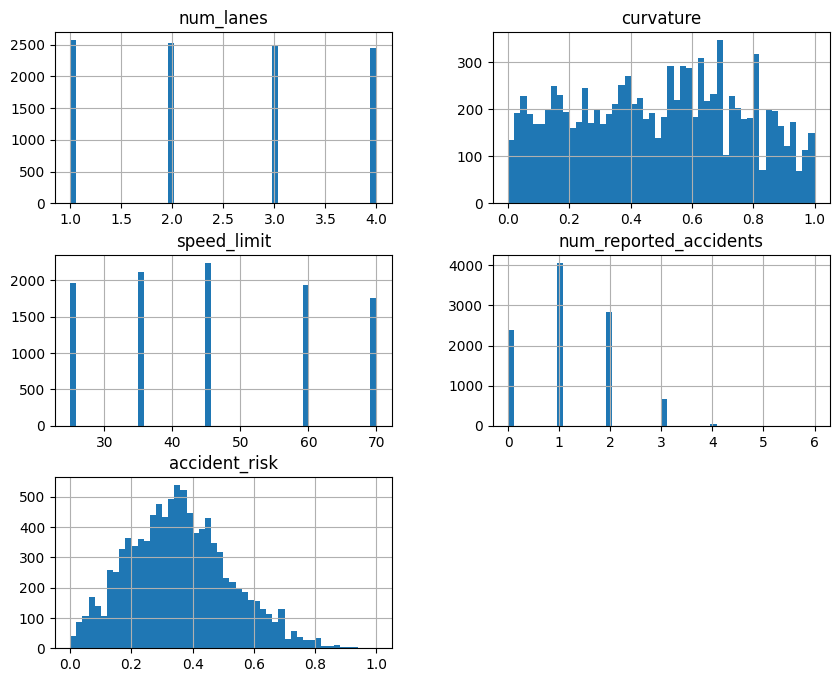

In [86]:
df.hist(bins=50, figsize=(10,8), column=[col for col in df.columns if col != 'id'])
plt.show()

Rozkład ryzyka jest zbliżony do normalnego, jednak widać lekką asymetrię prawostronną. Większość dróg ma niskie lub średnie ryzyko, a ekstremalnie niebezpieczne odcinki są rzadsze, co jest naturalne dla rzeczywistych danych drogowych.

Rozkłady zmiennych objaśniających kategorycznych

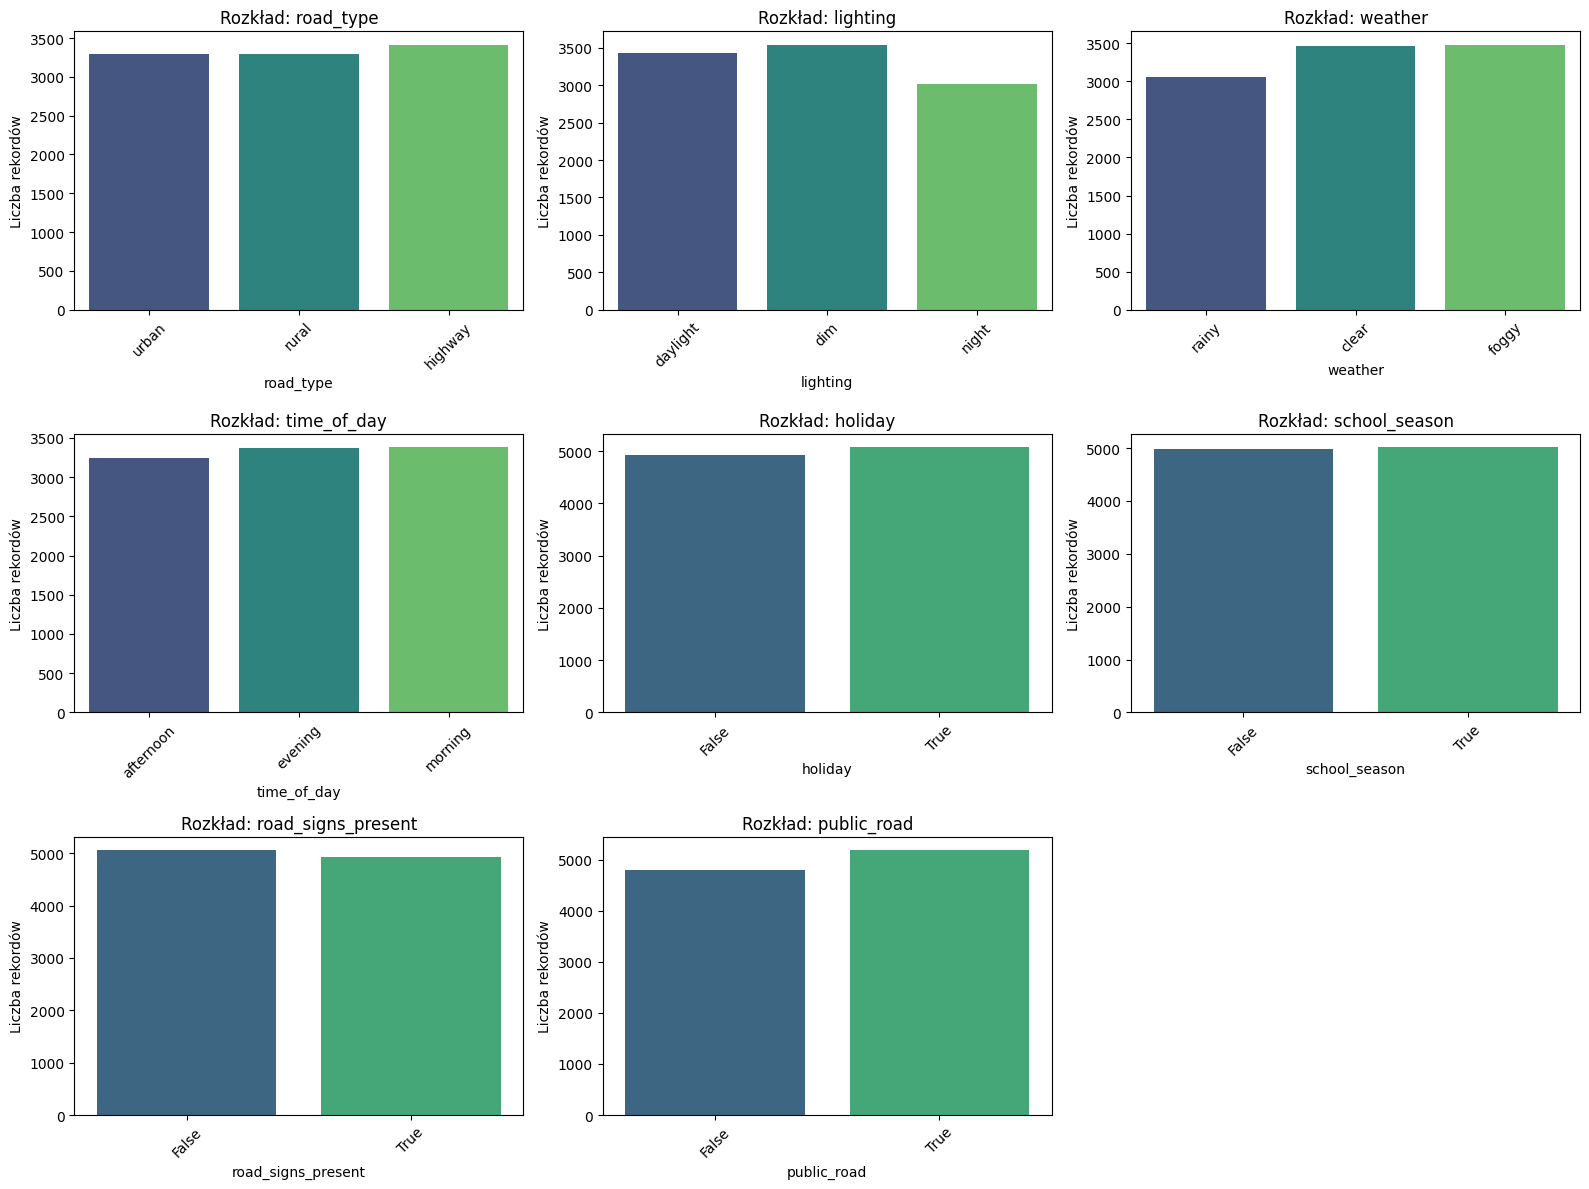


Statystyki dla road_type:
road_type
highway    3416
urban      3292
rural      3292
Name: count, dtype: int64

Statystyki dla lighting:
lighting
dim         3544
daylight    3434
night       3022
Name: count, dtype: int64

Statystyki dla weather:
weather
foggy    3483
clear    3462
rainy    3055
Name: count, dtype: int64

Statystyki dla time_of_day:
time_of_day
morning      3382
evening      3378
afternoon    3240
Name: count, dtype: int64

Statystyki dla holiday:
holiday
True     5077
False    4923
Name: count, dtype: int64

Statystyki dla school_season:
school_season
True     5017
False    4983
Name: count, dtype: int64

Statystyki dla road_signs_present:
road_signs_present
False    5063
True     4937
Name: count, dtype: int64

Statystyki dla public_road:
public_road
True     5192
False    4808
Name: count, dtype: int64


In [87]:
# 1. Definicja kolumn kategorycznych
# Wybieramy te, które mają typ 'object' lub są logiczne (bool)
categorical_cols = ['road_type', 'lighting', 'weather', 'time_of_day', 
                    'holiday', 'school_season', 'road_signs_present', 'public_road']

# 2. Tworzenie zbiorczego wykresu dla zmiennych kategorycznych
plt.figure(figsize=(16, 12))
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(categorical_cols):
    plt.subplot(3, 3, i + 1)
    # countplot pokazuje liczebność każdej kategorii
    sns.countplot(data=df, x=col, palette='viridis', hue=col, legend=False)
    plt.title(f'Rozkład: {col}')
    plt.xticks(rotation=45)
    plt.ylabel('Liczba rekordów')

plt.tight_layout()
plt.show()

# 3. Wyświetlenie dokładnych wartości liczbowych w konsoli
for col in categorical_cols:
    print(f"\nStatystyki dla {col}:")
    print(df[col].value_counts())

Analiza dwuzmiennowa (x i y)

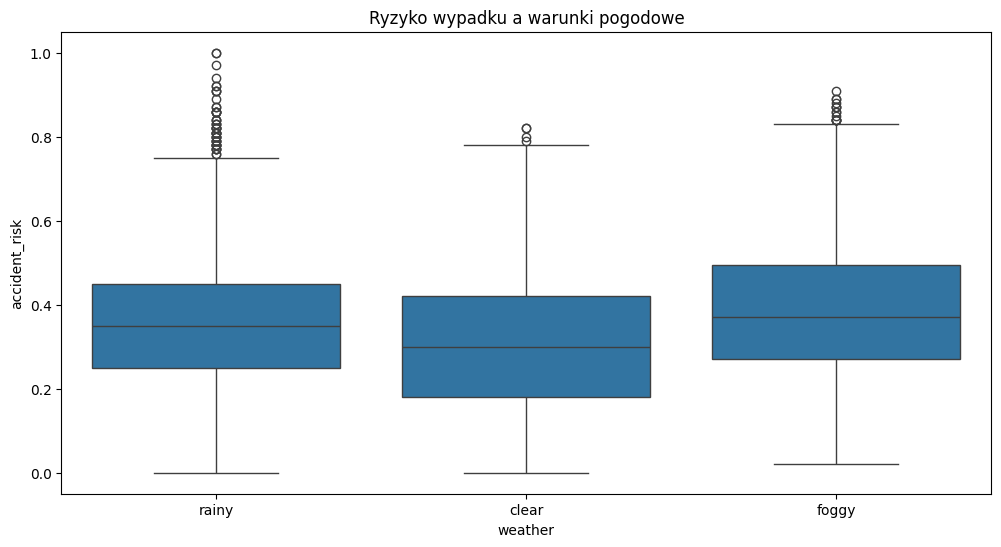

In [88]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='weather', y='accident_risk', data=df)
plt.title('Ryzyko wypadku a warunki pogodowe')
plt.show()

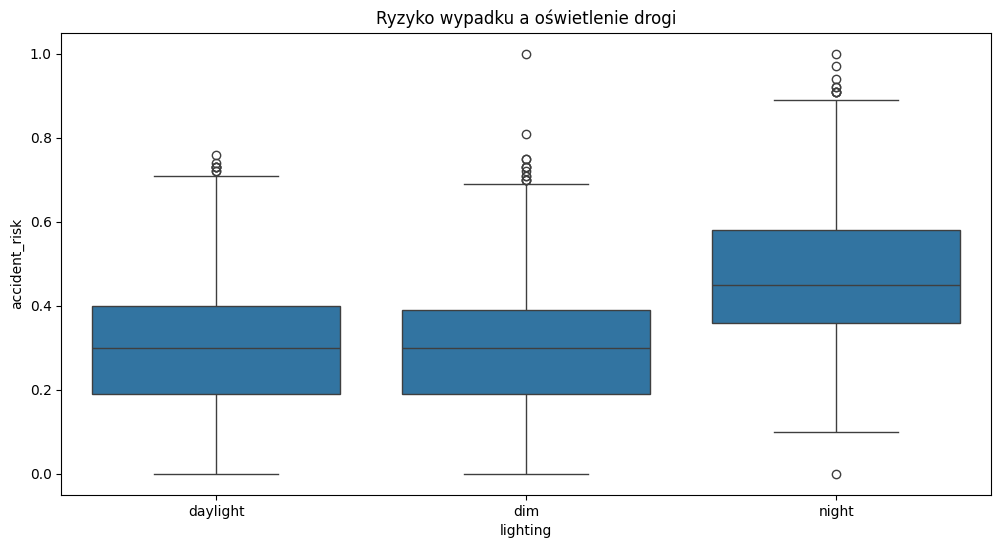

In [89]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='lighting', y='accident_risk', data=df)
plt.title('Ryzyko wypadku a oświetlenie drogi')
plt.show()

Analiza wykresu pudełkowego dla zmiennej lighting wykazała istotne różnice w rozkładzie ryzyka. Mediana ryzyka dla warunków nocnych (night) jest o ok. 15% wyższa niż w przypadku światła dziennego. Dodatkowo, warunki nocne charakteryzują się większą zmiennością (szersze pudełko), co sugeruje, że brak oświetlenia jest jednym z kluczowych czynników wpływających na niepewność modelu. Punkty nad "wąsami" (outliery) to wartości odstające. Pokazują one, że nawet w dzień (daylight) zdarzają się sytuacje o bardzo wysokim ryzyku (powyżej 0.7), mimo że typowe ryzyko jest niskie.

<Axes: xlabel='curvature', ylabel='accident_risk'>

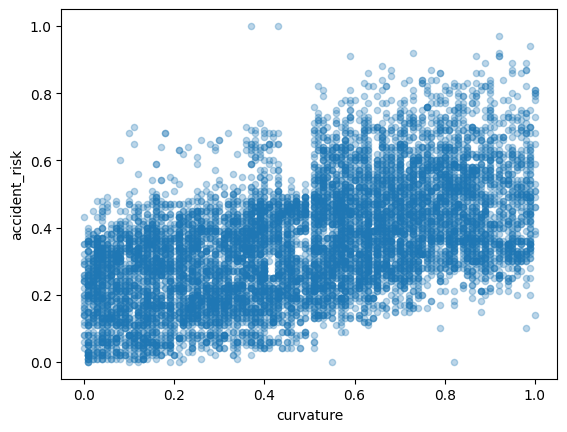

In [90]:
df.plot(kind='scatter', x='curvature',y='accident_risk', alpha=0.3)

Wykres rozrzutu z linią regresji wykazuje wyraźną korelację dodatnią między zakrzywieniem drogi a ryzykiem wypadku. Sugeruje to, że bardziej kręte odcinki dróg są trudniejsze dla kierowców i generują wyższe prawdopodobieństwo zdarzeń drogowych.

<Axes: xlabel='speed_limit', ylabel='accident_risk'>

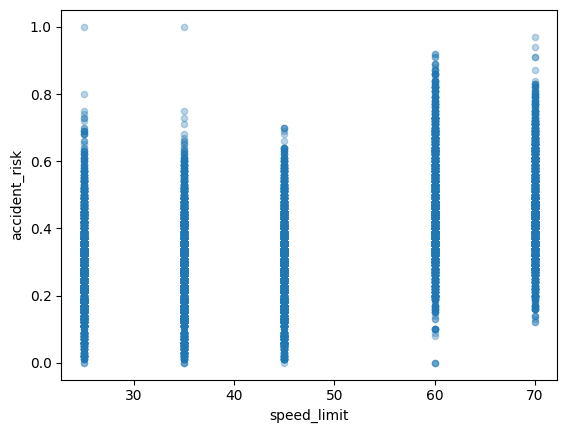

In [91]:
df.plot(kind='scatter', x='speed_limit',y='accident_risk', alpha=0.3)

Istnieje wyraźna dodatnia korelacja między dopuszczalną prędkością a ryzykiem wypadku.

<Axes: >

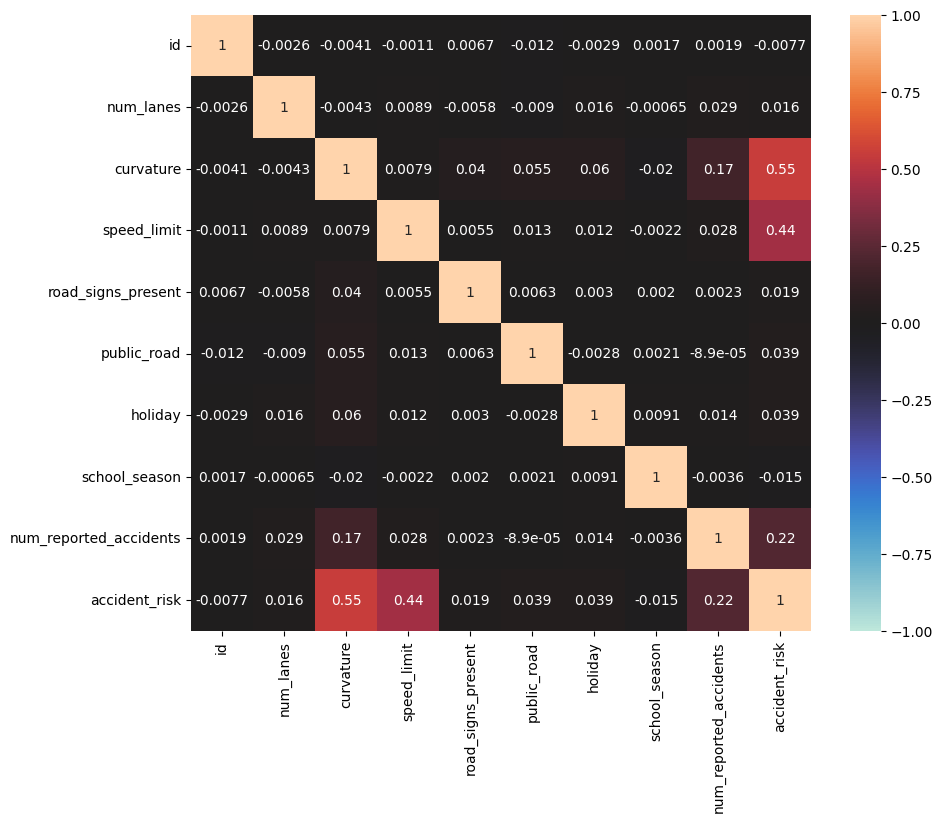

In [92]:
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, vmin=-1, center=0, vmax=1, annot=True)

Kolejno krzywizna drogi oraz ograniczenie prędkości mają najsilniejszy wpływ na ryzyko.

## Przygotowanie danych do modelu

In [93]:
# Usuwamy zbędne kolumny
df_cleaned = df.drop(['id', 'num_reported_accidents'], axis=1)

In [94]:
df_cleaned.isna().sum()

road_type             0
num_lanes             0
curvature             0
speed_limit           0
lighting              0
weather               0
road_signs_present    0
public_road           0
time_of_day           0
holiday               0
school_season         0
accident_risk         0
dtype: int64

In [95]:
onehot_encoder = OneHotEncoder()

columns_to_encode = ['road_type', 'lighting', 'weather', 'time_of_day']
data_to_encode = df_cleaned[columns_to_encode]
encoded_data = onehot_encoder.fit_transform(data_to_encode).toarray()
encoded_df = pd.DataFrame(encoded_data, columns=onehot_encoder.get_feature_names_out(input_features=columns_to_encode), index=data_to_encode.index)
df_onehotencoder = pd.concat([df_cleaned.drop(columns_to_encode, axis=1), encoded_df], axis=1)

# Zamiana wartości logicznych/binarnych na 0 i 1
binary_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']
for col in binary_cols:
    df_onehotencoder[col] = df_onehotencoder[col].astype(int)

onehot_columns=df_onehotencoder.columns.tolist()
print(df_onehotencoder.columns.tolist())
df_onehotencoder.head(5)


['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'accident_risk', 'road_type_highway', 'road_type_rural', 'road_type_urban', 'lighting_daylight', 'lighting_dim', 'lighting_night', 'weather_clear', 'weather_foggy', 'weather_rainy', 'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning']


,num_lanes,curvature,speed_limit,road_signs_present,public_road,holiday,school_season,accident_risk,road_type_highway,road_type_rural,road_type_urban,lighting_daylight,lighting_dim,lighting_night,weather_clear,weather_foggy,weather_rainy,time_of_day_afternoon,time_of_day_evening,time_of_day_morning
0,2,0.06,35,0,1,0,1,0.13,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,4,0.99,35,1,0,1,1,0.35,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4,0.63,70,0,1,1,0,0.30,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,4,0.07,35,1,1,0,0,0.21,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,0.58,60,0,0,1,0,0.56,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [96]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df_onehotencoder[onehot_columns]) 
print(np_scaled)

# Normalizacja L2 poprawiła zdolność generalizacji modelu Random Forest, co sugeruje, 
# że względne proporcje cech są ważniejsze niż ich wartości bezwzględne.
normalizer = Normalizer()
np_scaled_normalized = normalizer.fit_transform(np_scaled)
print(np_scaled_normalized)

df_scaled = pd.DataFrame(np_scaled_normalized)
df_scaled.columns = onehot_columns

df_scaled.head(5)

X = df_scaled[['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'road_type_highway', 'road_type_rural', 'road_type_urban', 'lighting_daylight', 'lighting_dim', 'lighting_night', 'weather_clear', 'weather_foggy', 'weather_rainy', 'time_of_day_afternoon', 'time_of_day_evening', 'time_of_day_morning']]
y = df_scaled['accident_risk']

[[-0.42774822 -1.56163365 -0.71047841 ...  1.44444444 -0.71422531
  -0.71486399]
 [ 1.36087072  1.85969163 -0.71047841 ... -0.69230769  1.40011841
  -0.71486399]
 [ 1.36087072  0.53530765  1.49764167 ... -0.69230769 -0.71422531
   1.3988675 ]
 ...
 [ 0.46656125  1.7493263   0.86675022 ...  1.44444444 -0.71422531
  -0.71486399]
 [ 1.36087072 -0.53155722 -0.07958696 ... -0.69230769 -0.71422531
   1.3988675 ]
 [-1.32205769  0.86640365 -1.34136986 ...  1.44444444 -0.71422531
  -0.71486399]]
[[-0.09284356 -0.33895554 -0.15421068 ...  0.3135194  -0.15502396
  -0.15516258]
 [ 0.29255134  0.39978469 -0.15273413 ... -0.14882791  0.30098856
  -0.15367692]
 [ 0.30434523  0.11971625  0.3349327  ... -0.15482775 -0.1597294
   0.31284284]
 ...
 [ 0.10001333  0.37499033  0.18579893 ...  0.30963503 -0.15310327
  -0.15324018]
 [ 0.31786256 -0.12415738 -0.01858936 ... -0.16170434 -0.1668237
   0.32673758]
 [-0.290431    0.19033245 -0.29467352 ...  0.31731705 -0.15690176
  -0.15704206]]


In [97]:
# Podział na Train i (Val+Test)
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.2, random_state=42)

# Podział reszty na Val i Test (pół na pół)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=42)

## Uczenie

### Machine Learning

In [98]:
regressors = {}
regressors['LinReg'] =LinearRegression()
regressors['Ridge'] = Ridge(alpha = .5)
regressors['Lasso'] = Lasso(alpha = 5.1)
regressors['ElNet'] =ElasticNet(alpha = .5, l1_ratio=0.5)
fit_results={}
for key in regressors:
    regr = regressors[key]
    regr.fit(X_train, y_train)
    # mean square error
    mse = mean_squared_error(y_test, regr.predict(X_test)) 
    rmse = np.sqrt(mean_squared_error(y_test, regr.predict(X_test)))
    r2score = r2_score(y_test, regr.predict(X_test))
    fit_results[key]= { 'MSE': mse, 'RMSE': rmse, 'R^2': r2score}
    print("{}\n----------\n  MSE={}\n  RMSE={}\n  R^2={}\n ".format(key,mse,rmse,r2score))

LinReg
----------
  MSE=0.009907060187081077
  RMSE=0.09953421616248895
  R^2=0.7946400458884813
 
Ridge
----------
  MSE=0.009906524390283857
  RMSE=0.09953152460544276
  R^2=0.7946511522311916
 
Lasso
----------
  MSE=0.04825591580262433
  RMSE=0.21967229184087905
  R^2=-0.0002798476745689005
 
ElNet
----------
  MSE=0.04825591580262433
  RMSE=0.21967229184087905
  R^2=-0.0002798476745689005
 


In [99]:
DTR = DecisionTreeRegressor()
DTR.fit(X_train,y_train)
y_pred_dt = DTR.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_dt))
mse = mean_squared_error(y_test, y_pred_dt)
r2score = r2_score(y_test, y_pred_dt)
print('MSE: %f'% mse)
print('RMSE: %f'% rmse)
print('R^2: %f'% r2score)


MSE: 0.007034
RMSE: 0.083872
R^2: 0.854186


In [100]:
DTR.feature_importances_

array([0.02210562, 0.32241414, 0.21308865, 0.00362724, 0.00479468,
       0.0052136 , 0.00446684, 0.00528052, 0.00378983, 0.00311049,
       0.00298291, 0.00352224, 0.28936918, 0.08282951, 0.00731074,
       0.01584806, 0.00376175, 0.0030589 , 0.00342513])

In [101]:
RFR = RandomForestRegressor()
RFR.fit(X_train,y_train)
y_pred_rf = RFR.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mse = mean_squared_error(y_test, y_pred_rf)
r2score = r2_score(y_test, y_pred_rf)
print('MSE: %f'% mse)
print('RMSE: %f'% rmse)
print('R^2: %f'% r2score)


MSE: 0.004516
RMSE: 0.067198
R^2: 0.906400


In [102]:
RFR.feature_importances_

array([0.02051168, 0.32232778, 0.21466466, 0.00468488, 0.00533307,
       0.00514932, 0.00493001, 0.00444979, 0.00374661, 0.00392996,
       0.00395835, 0.00388394, 0.28878403, 0.08149614, 0.00836548,
       0.01137473, 0.00442456, 0.00406685, 0.00391817])

In [103]:
GBR = GradientBoostingRegressor()
GBR.fit(X_train,y_train)
y_pred_rf = GBR.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mse = mean_squared_error(y_test, y_pred_rf)
r2score = r2_score(y_test, y_pred_rf)
print('MSE: %f'% mse)
print('RMSE: %f'% rmse)
print('R^2: %f'% r2score)

MSE: 0.005745
RMSE: 0.075793
R^2: 0.880921


In [104]:
GBR.feature_importances_

array([5.41660270e-03, 3.45451129e-01, 2.39690954e-01, 8.54047773e-05,
       4.82942577e-05, 1.37318555e-04, 1.30838581e-04, 3.88400885e-04,
       1.24416133e-04, 3.09206680e-04, 1.13781422e-03, 2.66723620e-03,
       3.23749875e-01, 7.45911198e-02, 3.28449578e-03, 1.95643198e-03,
       2.82037379e-04, 2.43485105e-04, 3.04939009e-04])

In [105]:
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, y_train)
y_svr_pred = svr_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_svr_pred))
mse = mean_squared_error(y_test, y_svr_pred)
r2score = r2_score(y_test, y_svr_pred)
print('MSE: %f'% mse)
print('RMSE: %f'% rmse)
print('R^2: %f'% r2score)

MSE: 0.008469
RMSE: 0.092025
R^2: 0.824456


In [106]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_knn_pred = knn_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_knn_pred))
mse = mean_squared_error(y_test, y_knn_pred)
r2score = r2_score(y_test, y_knn_pred)
print('MSE: %f'% mse)
print('RMSE: %f'% rmse)
print('R^2: %f'% r2score)

MSE: 0.014740
RMSE: 0.121407
R^2: 0.694467


Dla najlepszego modelu ML użycie GridSearchCV lub RandomSearchCV:

In [107]:
# from sklearn.model_selection import GridSearchCV

# # Definiujemy "siatkę" parametrów do sprawdzenia
# param_grid_rf = {
#     'n_estimators': [1000,1500],       # liczba drzew
#     'max_depth': [None, 20, 30],      # głębokość drzew
#     'min_samples_split': [2],      # min. liczba próbek do podziału węzła
#     'bootstrap': [True]        # czy używać losowych próbek ze zwracaniem
# }

# # Tworzymy obiekt GridSearchCV
# grid_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), 
#                        param_grid=param_grid_rf, 
#                        cv=3,          # 3-krotna walidacja krzyżowa
#                        scoring='r2', 
#                        n_jobs=-1,     # użyj wszystkich rdzeni procesora
#                        verbose=2)

# # Uruchamiamy poszukiwania
# grid_rf.fit(X_train, y_train)

# # Wyświetlamy najlepsze parametry
# print("Najlepsze parametry dla RF:", grid_rf.best_params_)
# print("Najlepszy wynik R^2:", grid_rf.best_score_)

# # Przypisujemy najlepszy model do zmiennej
# best_rf = grid_rf.best_estimator_
# y_pred_rf = best_rf.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
# mse = mean_squared_error(y_test, y_pred_rf)
# r2score = r2_score(y_test, y_pred_rf)
# print('MSE: %f'% mse)
# print('RMSE: %f'% rmse)
# print('R^2: %f'% r2score)

In [108]:
# Definiujemy rozkłady parametrów (szerszy zakres)
from scipy.stats import uniform


param_dist_rf = {
    'n_estimators': randint(100, 1000),           # Od 100 do 2000 drzew
    'max_depth': [None, 10, 20, 30],     # Szerszy wachlarz głębokości
    'min_samples_split': randint(2, 11),          # Losowo od 2 do 10
    'min_samples_leaf': randint(1, 5),            # Minimalna liczba próbek w liściu
    # Wymuszamy bootstrap=True, aby móc użyć max_samples (szybsze)
    'bootstrap': [True], 
    # Każde drzewo uczy się tylko na 60-90% losowych danych - to BARDZO przyspiesza
    'max_samples': uniform(0.6, 0.3)  # Losuje wartość od 0.6 do 0.9
}

# Tworzymy obiekt RandomizedSearchCV
random_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42), 
    param_distributions=param_dist_rf, 
    n_iter=10,           # Liczba losowych kombinacji do sprawdzenia (np. 10)
    cv=2,                # 2-krotna walidacja krzyżowa
    scoring='r2', 
    n_jobs=-1,           # Wszystkie rdzenie
    verbose=2,
    random_state=42      # Aby wyniki były powtarzalne
)

# Uruchamiamy poszukiwania
random_rf.fit(X_train, y_train)

# Wyświetlamy najlepsze parametry
print("Najlepsze parametry dla RF (RandomSearch):", random_rf.best_params_)
print("Najlepszy wynik R^2 z walidacji:", random_rf.best_score_)

# Przypisujemy najlepszy model i oceniamy na zbiorze testowym
best_rf = random_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mse = mean_squared_error(y_test, y_pred_rf)
r2score = r2_score(y_test, y_pred_rf)

print('\nWyniki na zbiorze testowym:')
print('MSE: %f' % mse)
print('RMSE: %f' % rmse)
print('R^2: %f' % r2score)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Najlepsze parametry dla RF (RandomSearch): {'bootstrap': True, 'max_depth': 30, 'max_samples': np.float64(0.8826605267054558), 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 876}
Najlepszy wynik R^2 z walidacji: 0.8936682767344455

Wyniki na zbiorze testowym:
MSE: 0.004573
RMSE: 0.067620
R^2: 0.905218


W procesie optymalizacji parametrów (punkt 4.1.2) wykorzystano technikę GridSearchCV. Uzyskany wynik $R^2 \approx 0,91$ na zbiorze testowym jest zbliżony do wyniku modelu bazowego, co potwierdza wysoką stabilność algorytmu Random Forest dla tego zbioru danych. Niewielkie różnice między średnim wynikiem walidacji krzyżowej ($0,90$) a wynikiem testowym ($0,91$) świadczą o dobrej zdolności modelu do generalizacji i braku istotnego przeuczenia.

Wniosek: Ocena modelu Random Forest (ML)

Skuteczność modelu: Algorytm Random Forest okazał się znacznie lepszy od regresji liniowej, podnosząc współczynnik determinacji z $0.79$ do $0.90$. Świadczy to o tym, że zależności w zbiorze danych mają charakter nieliniowy, a drzewa decyzyjne lepiej radzą sobie z wyłapywaniem interakcji między cechami (np. jednoczesny wpływ wysokiej prędkości i braku oświetlenia).

Precyzja przewidywań (RMSE): Błąd RMSE na poziomie 0.06 oznacza, że średnie odchylenie przewidywań modelu od rzeczywistego ryzyka wynosi zaledwie 6% w skali całego zbioru. Jest to wynik bardzo wysoki, pozwalający na realne zastosowanie modelu do oceny bezpieczeństwa dróg.

Stabilność (MSE): Wartość MSE bliska 0.00 wskazuje, że model rzadko popełnia błędy o dużej skali (tzw. outliery błędu), co jest kluczowe w systemach bezpieczeństwa drogowego.

### Deep Learning

In [109]:
ssn1 = Sequential()

In [110]:
ssn1.add(Input(shape=(X_train.shape[1],)))
ssn1.add(Dense(64, activation='relu'))
ssn1.add(Dropout(0.2)) # Zapobiega overfittingowi
ssn1.add(Dense(32, activation='relu'))
ssn1.add(Dense(1, activation = 'linear'))

In [111]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [112]:
ssn1.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

In [113]:
ssn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
training_history = ssn1.fit(X_train, 
                    y_train, 
                    epochs=50,
                    verbose=1,
                    batch_size = 32,
                    validation_data = (X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0207 - mae: 0.1116 - val_loss: 0.0101 - val_mae: 0.0801
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0122 - mae: 0.0873 - val_loss: 0.0093 - val_mae: 0.0770
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - mae: 0.0823 - val_loss: 0.0089 - val_mae: 0.0749
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0101 - mae: 0.0790 - val_loss: 0.0087 - val_mae: 0.0735
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0095 - mae: 0.0769 - val_loss: 0.0082 - val_mae: 0.0714
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0090 - mae: 0.0747 - val_loss: 0.0078 - val_mae: 0.0700
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - mae: 0.0724 - val_loss: 0.0076 - val_mae: 0.0691
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0082 - mae: 0.0714 - val_loss: 0.0074 - val_mae: 0.0679
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

In [115]:
y_pred=ssn1.predict(X_test)
mse = mean_squared_error(y_test, y_pred) 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2score = r2_score(y_test, y_pred)
fit_results[key]= { 'MSE': mse, 'RMSE': rmse, 'R^2': r2score}
print("{}\n----------\n  MSE={}\n  RMSE={}\n  R^2={}\n ".format(key,mse,rmse,r2score))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
ElNet
----------
  MSE=0.007039761011300927
  RMSE=0.0839032836741264
  R^2=0.8540752785450918
 


In [116]:
loss = training_history.history['loss']
mae = training_history.history['mae']
val_loss = training_history.history['val_loss']
val_mae = training_history.history['val_mae']

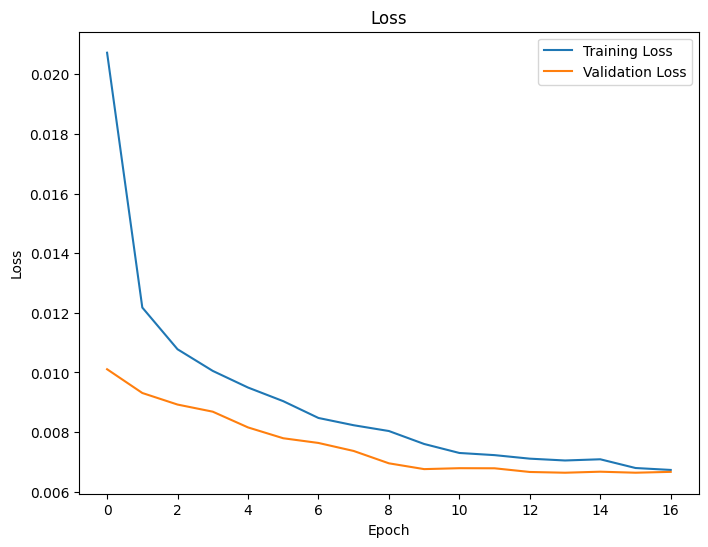

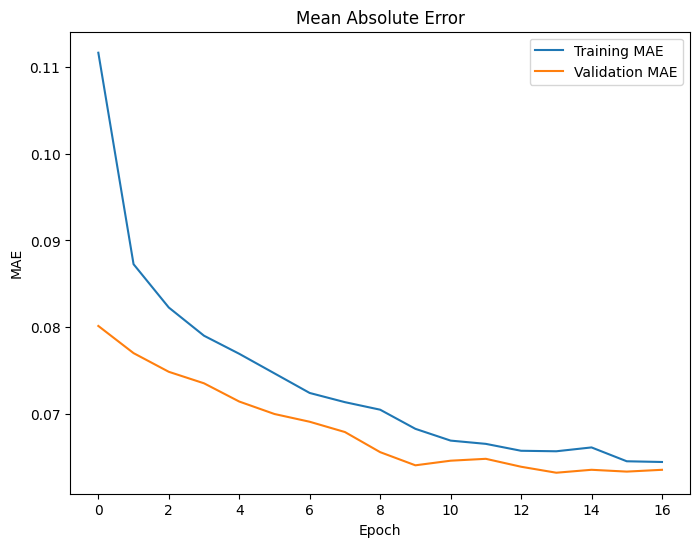

In [117]:
# wykres straty mse
plt.figure(figsize=(8, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# wykres straty mae
plt.figure(figsize=(8, 6))
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [118]:
test_loss, test_mae = ssn1.evaluate(X_test,  y_test, verbose=2)

32/32 - 0s - 3ms/step - loss: 0.0070 - mae: 0.0649


In [119]:
y_train_pred = ssn1.predict(X_train) 
y_test_pred = ssn1.predict(X_test) 

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Mimo zastosowania sieci neuronowej, klasyczny model Random Forest osiągnął wyraźnie lepsze wyniki wyjaśniające zależności w danych (R² = 0.91 vs 0.85). Wynika to z tablicowego charakteru danych oraz obecności nieliniowych interakcji i progów decyzyjnych, które są naturalnie modelowane przez drzewa decyzyjne. W analizowanym przypadku zwiększenie złożoności modelu (Deep Learning) nie prowadziło do poprawy jakości predykcji. Należy jednak zauważyć, że sieci neuronowe są metodami silnie zależnymi od wielkości zbioru danych i w przypadku znacznie większej liczby obserwacji mogłyby osiągnąć porównywalne lub lepsze rezultaty.

## XAI

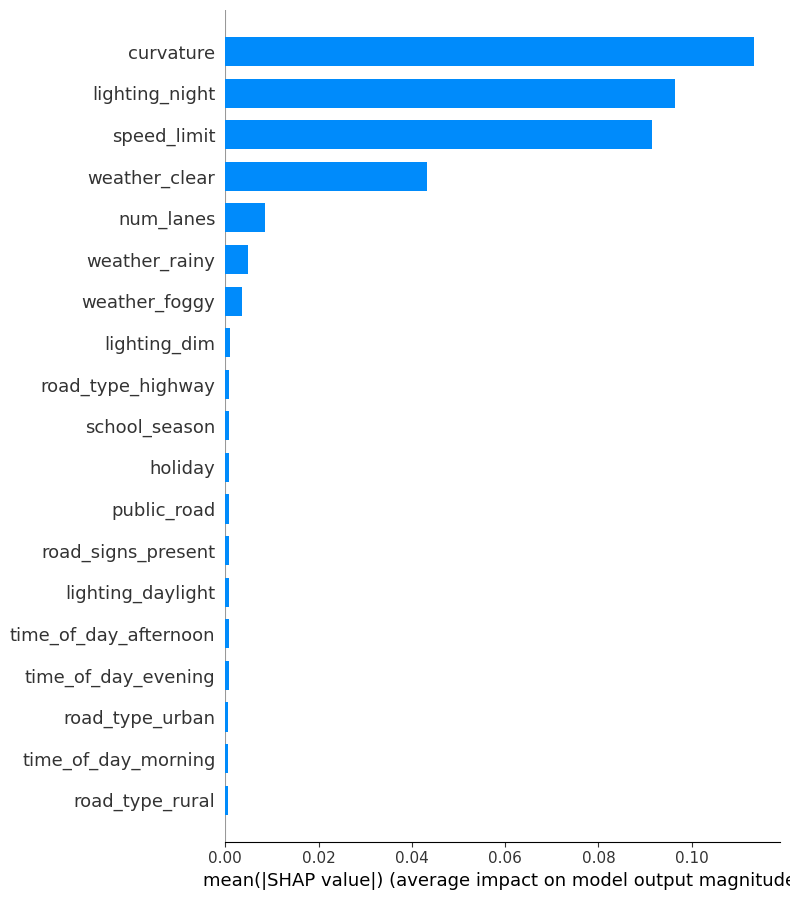

In [ ]:
import shap
import matplotlib.pyplot as plt

# 1. OPTYMALIZACJA: Weź tylko próbkę danych (np. 300 wierszy). 
X_test_sample = X_test.sample(300, random_state=42)

# 2. Inicjalizacja explainera
explainer = shap.TreeExplainer(best_rf)

# 3. Obliczenie wartości SHAP tylko dla próbki
shap_values = explainer.shap_values(X_test_sample)

# --- WIZUALIZACJA GLOBALNA ---
# To pokaże, które cechy (np. speed_limit) są najważniejsze ogólnie
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, feature_names=X_test_sample.columns.tolist(), plot_type="bar")

Analiza globalna SHAP wskazuje że cztery cechy mają dominujący wpływ na model: curvature, lighting_night, speed_limit oraz weather_clear.

In [129]:
# --- WIZUALIZACJA LOKALNA (Dla jednego przypadku) ---
# Force plot dla regresji wygląda inaczej niż dla klasyfikacji (nie ma class_idx!)

import numpy as np
import matplotlib.pyplot as plt

# 1. Zrób predykcje dla naszej małej próbki, żeby wiedzieć, gdzie jest min i max
predictions_sample = best_rf.predict(X_test_sample)

# 2. Znajdź indeksy skrajnych przypadków
min_risk_idx = np.argmin(predictions_sample) # Indeks najbezpieczniejszej drogi
max_risk_idx = np.argmax(predictions_sample) # Indeks najniebezpieczniejszej drogi

print(f"Najniższe ryzyko (indeks {min_risk_idx}): {predictions_sample[min_risk_idx]:.4f}")
print(f"Najwyższe ryzyko (indeks {max_risk_idx}): {predictions_sample[max_risk_idx]:.4f}")

# 3. Wizualizacja PRZYPADKU BEZPIECZNEGO
print("\n--- Analiza przypadku BEZPIECZNEGO ---")
shap.initjs()
display(shap.force_plot(
    explainer.expected_value, 
    shap_values[min_risk_idx], 
    X_test_sample.iloc[min_risk_idx]
))

# 4. Wizualizacja PRZYPADKU NIEBEZPIECZNEGO
print("\n--- Analiza przypadku NIEBEZPIECZNEGO ---")
shap.initjs()
display(shap.force_plot(
    explainer.expected_value, 
    shap_values[max_risk_idx], 
    X_test_sample.iloc[max_risk_idx]
))

# 5. Wizualizacja PRZYPADKU LOSOWEGO
print("\n--- Analiza przypadku LOSOWEGO ---")
random_idx = np.random.randint(0, len(X_test_sample))
shap.initjs()
display(shap.force_plot(
    explainer.expected_value, 
    shap_values[random_idx], 
    X_test_sample.iloc[random_idx]
))

Najniższe ryzyko (indeks 241): -0.4171
Najwyższe ryzyko (indeks 13): 0.5718

--- Analiza przypadku BEZPIECZNEGO ---



--- Analiza przypadku NIEBEZPIECZNEGO ---



--- Analiza przypadku LOSOWEGO ---


W force plot:

liczba przy cesze = wartość cechy (po przetwarzaniu)

długość paska (wartość bezwzględna SHAP wartości) = siła wpływu 

kolor = kierunek wpływu

W bezpiecznym przypadku cechy takie jak: trasa niekręta (-0.3013), pogoda dobra (0.2927), oświetlenie nienocne (-0.1402), limit prędkości niewysoki (-0.016) wygenerowały standaryzowane ryzyko równe -0.42, które jest mniejsze od bazowego (-0.002). Zakrzywienie drogi było najsilniejszym czynnikiem.

W niebezpiecznym przypadku cechy takie jak: trasa kręta (0.1611), oświetlenie nocne (0.271), limit prędkości wysoki (0.1546), pogoda deszczowa (0.2689) wygenerowały standaryzowane ryzyko równe 0.57, które jest większe od bazowego (-0.002). Zakrzywienie drogi było najsilniejszym czynnikiem.

W losowym przypadku cechy takie jak: pogoda niedobra (-0.1606), trasa kręta (0.1182), limit prędkości wysoki (0.3306), oświetlenie nienocne (-0.1453) wygenerowały standaryzowane ryzyko równe 0.14, które jest większe od bazowego (-0.002). Limit prędkości był najsilniejszym czynnikiem.